Problem Statement: We want to classify the degree of truth in the statements of influential people. The data contains the statement itself, the person, and meta-data about the topic, and polical affiliations. Each statement is labelled with six categories: 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'true'. We can frame this problem as a machine learning problem which has multiple classes.

# Import data

In [97]:
import pandas as pd
train = pd.read_csv('liar_dataset/train.tsv', sep='\t')
train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

test = pd.read_csv('liar_dataset/test.tsv', sep='\t')
test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

val = pd.read_csv('liar_dataset/valid.tsv', sep='\t')
val.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

## 0.1 Helper Functions

In [2]:
from typing import List
import numpy as np

In [3]:
def MakeDF(colNames: List, df:pd):
    newDf = pd.DataFrame()
    for colName in colNames:
        newDf = pd.concat([newDf, df[colName]], axis=1)
    return newDf

speakerLieCountHeaders = ['barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts']
trainSpeakerLieCounts = MakeDF(speakerLieCountHeaders, train)
testSpeakerLieCounts = MakeDF(speakerLieCountHeaders, test)

# 1 Conduct Exploratory Data Analysis

## 1.1 Check dataframe info (Non-Nulls, Counts, Data types)

In [148]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10239 non-null  object 
 1   label              10239 non-null  object 
 2   statement          10239 non-null  object 
 3   subject            10237 non-null  object 
 4   speaker            10237 non-null  object 
 5   spkrJobTitle       7342 non-null   object 
 6   state              8031 non-null   object 
 7   party              10237 non-null  object 
 8   barelyTrueCounts   10237 non-null  float64
 9   falseCounts        10237 non-null  float64
 10  halfTrueCounts     10237 non-null  float64
 11  mostlyTrueCounts   10237 non-null  float64
 12  pantsOnFireCounts  10237 non-null  float64
 13  context            10137 non-null  object 
 14  wordsStemmed       10239 non-null  object 
 15  wordsUnstemmed     10239 non-null  object 
dtypes: float64(5), object(

In [150]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1266 non-null   object
 1   label              1266 non-null   object
 2   statement          1266 non-null   object
 3   subject            1266 non-null   object
 4   speaker            1266 non-null   object
 5   spkrJobTitle       941 non-null    object
 6   state              1004 non-null   object
 7   party              1266 non-null   object
 8   barelyTrueCounts   1266 non-null   int64 
 9   falseCounts        1266 non-null   int64 
 10  halfTrueCounts     1266 non-null   int64 
 11  mostlyTrueCounts   1266 non-null   int64 
 12  pantsOnFireCounts  1266 non-null   int64 
 13  context            1249 non-null   object
 14  wordsStemmed       1266 non-null   object
 15  wordsUnstemmed     1266 non-null   object
dtypes: int64(5), object(11)
memory usage: 158.

In [149]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1283 non-null   object
 1   label              1283 non-null   object
 2   statement          1283 non-null   object
 3   subject            1283 non-null   object
 4   speaker            1283 non-null   object
 5   spkrJobTitle       938 non-null    object
 6   state              1004 non-null   object
 7   party              1283 non-null   object
 8   barelyTrueCounts   1283 non-null   int64 
 9   falseCounts        1283 non-null   int64 
 10  halfTrueCounts     1283 non-null   int64 
 11  mostlyTrueCounts   1283 non-null   int64 
 12  pantsOnFireCounts  1283 non-null   int64 
 13  context            1271 non-null   object
 14  wordsStemmed       1283 non-null   object
 15  wordsUnstemmed     1283 non-null   object
dtypes: int64(5), object(11)
memory usage: 160.

## 1.2 Check Nulls and Nans

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def PlotMissingData(df, dataName:str):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    figName = 'missingData' + dataName + '.png'
    plt.savefig(figName, dpi=100)
    plt.title(figName, fontsize =20)
    plt.show()

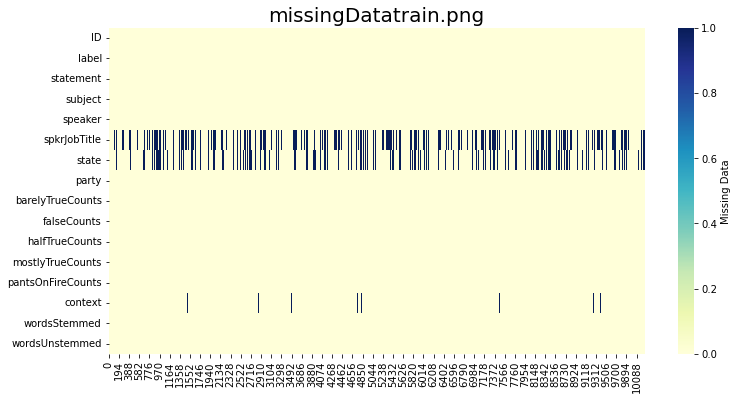

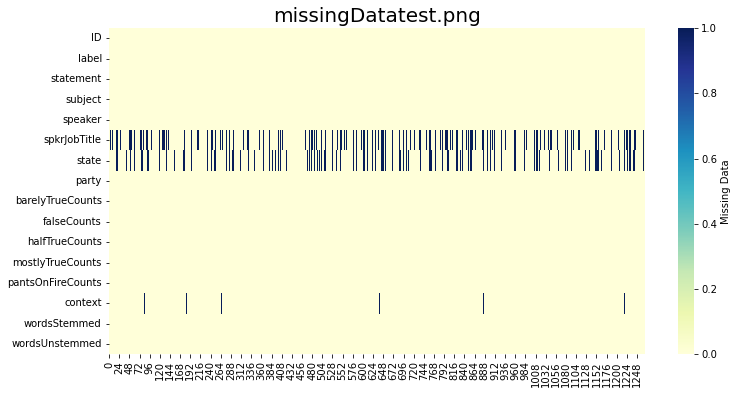

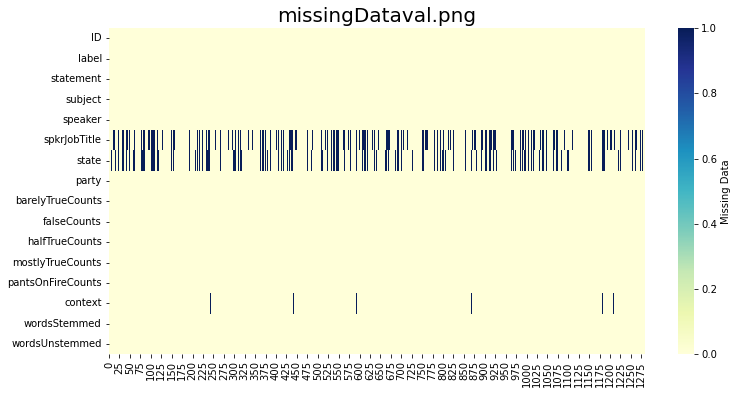

In [151]:
PlotMissingData(train, 'train')
PlotMissingData(test, 'test')
PlotMissingData(val, 'val')

In [158]:
# Count Nulls
trainMissing = train.isnull().sum()
testMissing = test.isnull().sum()
valMissing = val.isnull().sum()

print(trainMissing)
print(testMissing)
print(valMissing)

ID                      0
label                   0
statement               0
subject                 2
speaker                 2
spkrJobTitle         2897
state                2208
party                   2
barelyTrueCounts        2
falseCounts             2
halfTrueCounts          2
mostlyTrueCounts        2
pantsOnFireCounts       2
context               102
wordsStemmed            0
wordsUnstemmed          0
dtype: int64
ID                     0
label                  0
statement              0
subject                0
speaker                0
spkrJobTitle         325
state                262
party                  0
barelyTrueCounts       0
falseCounts            0
halfTrueCounts         0
mostlyTrueCounts       0
pantsOnFireCounts      0
context               17
wordsStemmed           0
wordsUnstemmed         0
dtype: int64
ID                     0
label                  0
statement              0
subject                0
speaker                0
spkrJobTitle         345
state   

## 1.3 Check duplicates

In [160]:
def CheckDuplicateIDs(df):
    duplicateIDs = []
    for count in df.ID.value_counts():
        if count > 1:
            duplicateIDs.append(df.ID)
    if duplicateIDs:
        return duplicateIDs
    else:
        return 0

duplicateTrainIDs = CheckDuplicateIDs(train)
duplicateTestIDs = CheckDuplicateIDs(test)
duplicateValIDs = CheckDuplicateIDs(val)
print(f'Duplicates in Train:{duplicateTrainIDs}, Test:{duplicateTestIDs}, Val:{duplicateValIDs}')


Duplicates in Train:0, Test:0, Va:0


## 1.4 Check Quantitative


(array([1654.,    0., 2114.,    0., 1994.,    0., 1962.,    0., 1676.,
         839.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

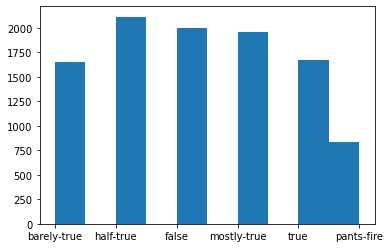

In [161]:
plt.hist(train['label']) # Pants-fire has 750 counts vs. the other classes which have approx 1500-2000 counts.

## 1.5 Check Qualitative

In [163]:
print(f"Unique speakers: {train['speaker'].nunique()} \n")
print(f"Percent unique speakers vs. all train data: {train['speaker'].nunique() / len(train):.2f} \n")
print(train['speaker'].value_counts())

Unique speakers: 2909 

Percent unique speakers vs. all train data: 0.28 

barack-obama                   488
donald-trump                   273
hillary-clinton                239
mitt-romney                    176
scott-walker                   149
                              ... 
david-pennington                 1
sandra-cunningham                1
cynthia-lummis                   1
yes-62-death-penalty-repeal      1
bill-belichick                   1
Name: speaker, Length: 2909, dtype: int64


# 2 Preprocess 

## 2.1 Get Unique List of Subjects, Contexts, Speakers

In [222]:
listOfSubjects = list(train['subject'])

In [217]:
from collections import defaultdict
import itertools
import operator

def CountListOfList(listOfList):
    countDict = defaultdict(int)
    for subjects in train['subject'].items():
        for subject in subjects:
            countDict[subject] += 1
    sortedCount = dict(sorted(countDict.items(), key=operator.itemgetter(1),reverse=True))

    return sortedCount

<BarContainer object of 20 artists>

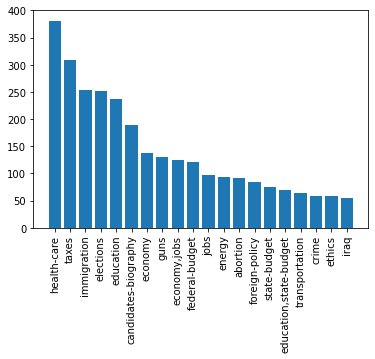

In [223]:
subjects = CountListOfList(listOfSubjects)
top20subjects = dict(itertools.islice(subjects.items(), 20)) # Get top 20 topics
plt.xticks(rotation='vertical')
plt.bar(top20subjects.keys(), top20subjects.values())

## 2.2 Process each statement

In [15]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
def RemovePunctuation(sentence: str, punctuations: str) -> str:
    noPunctuation = ""
    for char in sentence:
        if char not in punctuations:
            noPunctuation = noPunctuation + char
    return noPunctuation

In [17]:
def ProcessStatement(statements: List[str], punctuations: str, cachedStopWords: List, snowballStemmer: SnowballStemmer, stem=True) -> List[str]:

    processedStatements = []
    for statement in statements:
        # Make lower case
        _statement = statement.lower()

        # Remove punctuation
        _statement = RemovePunctuation(_statement, punctuations)
        
        # Remove numbers
        _statement  = re.sub('\w*\d\w*', '', _statement) 

        # Split/Tokenise
        _statement = _statement.split(' ') 

        _wordlist = []
        for word in _statement:
            # Exclude stop word. Exclude one-letter words
            if not word in cachedStopWords and len(word) > 1:
                # Stem the word
                if stem:
                    _wordlist.append(snowballStemmer.stem(word))
                else:
                    _wordlist.append(word)
        processedStatements.append(_wordlist)
    
    return processedStatements

In [99]:
cachedStopWords = stopwords.words("english")
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
snowballStemmer = SnowballStemmer('english')

statements = [list(train['statement']), list(val['statement']), list(test['statement'])]

trainWordsStemmed   = ProcessStatement(statements[0], punctuations, cachedStopWords, snowballStemmer, stem=True)
trainWordsUnstemmed = ProcessStatement(statements[0], punctuations, cachedStopWords, snowballStemmer, stem=False)

valWordsStemmed   = ProcessStatement(statements[1], punctuations, cachedStopWords, snowballStemmer, stem=True)
valWordsUnstemmed = ProcessStatement(statements[1], punctuations, cachedStopWords, snowballStemmer, stem=False)

testWordsStemmed    = ProcessStatement(statements[2], punctuations, cachedStopWords, snowballStemmer, stem=True)
testWordsUnstemmed  = ProcessStatement(statements[2], punctuations, cachedStopWords, snowballStemmer, stem=False)

In [106]:
train['wordsStemmed'] = trainWordsStemmed
train['wordsUnstemmed'] = trainWordsUnstemmed
val['wordsStemmed'] = valWordsStemmed
val['wordsUnstemmed'] = valWordsUnstemmed
test['wordsStemmed'] = testWordsStemmed
test['wordsUnstemmed'] = testWordsUnstemmed

## 2.3 One hot encode some of the MetaData

In [101]:
speakerOhe = pd.get_dummies(train['speaker']) 
partyOhe = pd.get_dummies(train['party'])

# 3 Feature Engineering

## 3.1 Embed using Word2Vec

In [102]:
from gensim.models import Word2Vec, KeyedVectors
pretrainedpath = "GoogleNews-vectors-negative300.bin"
w2vModel = KeyedVectors.load_word2vec_format(pretrainedpath,binary=True)
print('done loading Word2Vec')

done loading Word2Vec


In [103]:
def EmbedWords(processedStatements: List[List]) -> List:
    """Averages word embeddings in a sentence to return a word vector"""
    DIMENSION = 300
    zeroVector = np.zeros(DIMENSION)
    wordVectors = []
    excludedWordCount = 0
    excludedWords = []
    totalCount = 0

    for tokens in processedStatements:
        currentVector = zeroVector
        tokenCount = 0
        for token in tokens:
            totalCount += 1
            if token in w2vModel:
                currentVector += w2vModel[token]
                tokenCount += 1
            else:
                excludedWordCount += 1
                excludedWords.append(token)
        wordVectors.append(currentVector/tokenCount)
    return wordVectors, (excludedWords, excludedWordCount/totalCount)

In [107]:
# Need to use unstemmed words to match the words in word2vec "GoogleNews-vectors-negative300.bin" model
trainVec, trainVecLog = EmbedWords(train['wordsUnstemmed']) # 3% of token words excluded. Acceptable.
valVec, valVecLog = EmbedWords(val['wordsUnstemmed']) # 3% of token words excluded. Acceptable.
testVec, testVecLog = EmbedWords(test['wordsUnstemmed']) # 3% of token words excluded. Acceptable.

# 4 Train Multiclass Classifiers

In [143]:
# Randomise rows of data
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)

## 4.1 Baseline Models (Bag of Words)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn import metrics

In [139]:
def trainBaselineModels(xTrain, yTrain, xVal, yVal):
    # Initialise models
    models = [naive_bayes.MultinomialNB(), KNeighborsClassifier(), LogisticRegression(C=1.0, max_iter=10000)]
    modelName = ['NB MultiNomninal', 'KNN', 'Logistic']

    accuracies = []
    for model in models:

        # Fit model on training data and labels
        model.fit(xTrain, yTrain)

        # Predict on test data
        predictions = model.predict(xVal)

        # Check accuracy
        accuracy = metrics.accuracy_score(yVal, predictions)
        accuracies.append(accuracy)

    # Print Accuracy
    for i in range(3):
        print(f'{modelName[i]} Accuracy: {accuracies[i]:.2f}')

    # Evaluate Precision, Recall, F1-Score for Logistic
    print('\n Classification Report for Logistic Model')
    print(metrics.classification_report(val['label'], predictions))

    # Evaluate Confusion Matrix for Logistic
    print('\n Confusion Matrix for Logistic Model')
    cmDisp = metrics.ConfusionMatrixDisplay.from_predictions(yVal, predictions, xticks_rotation='vertical')


### 4.1.1 CountVectorizer

NB MultiNomninal Accuracy: 0.25
KNN Accuracy: 0.23
Logistic Accuracy: 0.25

 Classification Report for Logistic Model
              precision    recall  f1-score   support

 barely-true       0.24      0.21      0.22       236
       false       0.27      0.32      0.29       263
   half-true       0.23      0.24      0.23       248
 mostly-true       0.26      0.25      0.26       251
  pants-fire       0.26      0.15      0.19       116
        true       0.22      0.27      0.24       169

    accuracy                           0.25      1283
   macro avg       0.25      0.24      0.24      1283
weighted avg       0.25      0.25      0.24      1283


 Confusion Matrix for Logistic Model


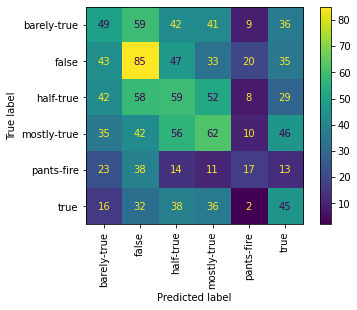

In [140]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation)
countVec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

# Fit vectorizer to the corpus
countVec.fit(train['statement'])

# Transform training and val statements
xTrain = countVec.transform(train['statement'])
xVal = countVec.transform(val['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'])

### 4.1.2 TfidVectorizer (replaces counts with floats)

NB MultiNomninal Accuracy: 0.24
KNN Accuracy: 0.22
Logistic Accuracy: 0.25

 Classification Report for Logistic Model
              precision    recall  f1-score   support

 barely-true       0.25      0.18      0.21       236
       false       0.28      0.37      0.32       263
   half-true       0.22      0.29      0.25       248
 mostly-true       0.26      0.25      0.26       251
  pants-fire       0.45      0.09      0.14       116
        true       0.21      0.21      0.21       169

    accuracy                           0.25      1283
   macro avg       0.28      0.23      0.23      1283
weighted avg       0.26      0.25      0.24      1283


 Confusion Matrix for Logistic Model


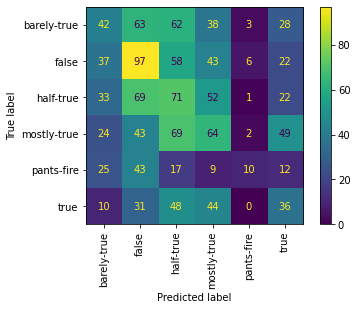

In [141]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation)
tfv = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

# Fit vectorizer to the corpus
tfv.fit(train['statement'])

# Transform training and val statements
xTrain = tfv.transform(train['statement'])
xVal= tfv.transform(val['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'])

### 4.1.3 Ngram range 1 to 3

NB MultiNomninal Accuracy: 0.24
KNN Accuracy: 0.25
Logistic Accuracy: 0.26

 Classification Report for Logistic Model
              precision    recall  f1-score   support

 barely-true       0.24      0.14      0.18       236
       false       0.28      0.32      0.30       263
   half-true       0.24      0.42      0.30       248
 mostly-true       0.28      0.30      0.29       251
  pants-fire       0.43      0.03      0.05       116
        true       0.27      0.21      0.23       169

    accuracy                           0.26      1283
   macro avg       0.29      0.24      0.22      1283
weighted avg       0.28      0.26      0.24      1283


 Confusion Matrix for Logistic Model


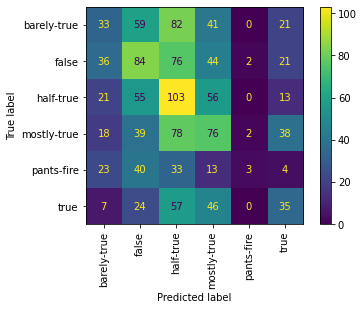

In [142]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation). Specifically try ngrams ranges 1 to 3
tfv = TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1, 3))

# Fit vectorizer to the corpus
tfv.fit(train['statement'])

# Transform training and val statements
xTrain = tfv.transform(train['statement'])
xVal = tfv.transform(val['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'])

## 4.2 Use Baseline Models but with Word2Vec Instead

KNN Accuracy: 0.16
Logistic Accuracy: 0.19

 Classification Report for Logistics Model
              precision    recall  f1-score   support

 barely-true       0.12      0.05      0.07       236
       false       0.16      0.20      0.18       263
   half-true       0.19      0.38      0.25       248
 mostly-true       0.22      0.24      0.23       251
  pants-fire       0.00      0.00      0.00       116
        true       0.22      0.12      0.15       169

    accuracy                           0.19      1283
   macro avg       0.15      0.16      0.15      1283
weighted avg       0.16      0.19      0.16      1283


 Confusion Matrix for Logistics Model


C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

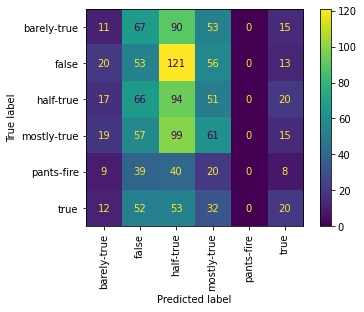

In [224]:
# Use the Word2Vec embedding created earlier. Note: NaiveBayes doesn't work with negative numbers
models = [KNeighborsClassifier(), LogisticRegression(C=1.0, max_iter=10000)]
modelName = ['KNN', 'Logistic']

accuracies = []
for model in models:

    # Fit model on training data and labels
    model.fit(xTrain, train['label'])

    # Predict on test data
    predictions = model.predict(xVal)

    # Check accuracy
    accuracy = metrics.accuracy_score(val['label'], predictions)
    accuracies.append(accuracy)

# Print Accuracy
for i in range(0, len(models)):
    print(f'{modelName[i]} Accuracy: {accuracies[i]:.2f}')

# Evaluate Precision, Recall, F1-Score for Logistics
print('\n Classification Report for Logistics Model')
print(metrics.classification_report(val['label'], predictions))

# Evaluate Confusion Matrix for Logistics
print('\n Confusion Matrix for Logistics Model')
cmDisp = metrics.ConfusionMatrixDisplay.from_predictions(val['label'], predictions, xticks_rotation='vertical')

# 4.3 Deep learning: LSTM Model
For word embeddings use one of the following options: embedding layer in Keras, Word2Vec, GloVE. You have the freedom to pick your own deep learning architecture.
- Most common architectures are CNNs and RNNs. LSTMs are a popular form of RNN.
- LSTMs are popular because they handle sequential data whereas CNNs don't.
- Recent approachs also involve starting with large, pre-trained language model and fine-tuning them for the task at hand.

In [29]:
import keras
import tensorflow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # This is now fully integrated into tensorflow
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Embedding, LSTM
from keras.models import Sequential
from keras import layers

### 4.3.1 Word Embedding for LSTM
1. tokenise the texts and convert into word index vectors
1. Pad the text sequence so that all texts are the same length
1. Map every word index to an embedding vector by multiplying word index vectors with the embedding matrix (pre-trained embeddings or custom embedding)

In [30]:
# Define constants for the LSTM
MARGIN = 1
maxStatement = max(train['statement'].max(), test['statement'].max())
MAX_SEQUENCE_LENGTH = len(maxStatement) * MARGIN
MAX_NUM_WORDS = len(maxStatement.split()) * MARGIN
EMBEDDING_DIM = 100

print(f'Longest statement: {maxStatement}')
print(f'Max sequence length: {len(maxStatement)}, Max words: {len(maxStatement.split())}')
print(f'MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}, MAX_NUM_WORDS: {MAX_NUM_WORDS}')

Longest statement: ﻿﻿Since Mayor Kennedy OBrien took office Sayreville has issued 22,081 building permits! Now OBrien is holding secret meetings with big developers.
Max sequence length: 146, Max words: 21
MAX_SEQUENCE_LENGTH: 146, MAX_NUM_WORDS: 21


In [91]:
# Convert labels from categoricals to one hot encoded columns
numData = 50  # DON'T FORGET TO RESET
le = LabelEncoder()
le.fit(train['label'].head(numData)) # DON'T FORGET TO RESET
labelMap = dict(zip(le.classes_, le.transform(le.classes_))) 
print(f'Label Map: {labelMap}')

# Convert String labels to Integers
yTrainIntClass = le.transform(train['label'].head(numData)) # DON'T FORGET TO RESET
yTestIntClass = le.transform(test['label'].head(numData)) # DON'T FORGET TO RESET
labelMapIntAsKey = {value:key for key, value in labelMap.items()} # Make integer keys and strings the values. Used in metrics

# Convert to OHE
NUM_CLASSES = len(labelMap)
yTrain = to_categorical(yTrainIntClass, NUM_CLASSES)
yTest = to_categorical(yTestIntClass, NUM_CLASSES)


Label Map: {'barely-true': 0, 'false': 1, 'half-true': 2, 'mostly-true': 3, 'pants-fire': 4, 'true': 5}


In [72]:
# Create Word Index
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train['statement'].head(numData)) # DON'T FORGET TO RESET
trainSequences = tokenizer.texts_to_sequences(train['statement'].head(numData))  # DON"T FORGET TO RESET
testSequences = tokenizer.texts_to_sequences(test['statement'].head(numData)) # DON'T FORGET TO RESET
wordIndex = tokenizer.word_index

# Pad sequences with zeros until max sequence length
trainData = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH) 
testData = pad_sequences(testSequences, maxlen=MAX_SEQUENCE_LENGTH)

In [78]:
# Use Stanford Glove to create
embeddingDict = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddingDict[word] = np.asarray(values[1:], dtype='float32')
        numWords = min(MAX_NUM_WORDS, len(wordIndex)) + 1
        embeddingMatrix = np.zeros((numWords, EMBEDDING_DIM))
        
for word, i in wordIndex.items():
    if i > MAX_NUM_WORDS:
        continue
    embeddingVec = embeddingDict.get(word)
    if embeddingVec is not None:
        embeddingMatrix[i] = embeddingVec

In [79]:
# Create Embedding Layer
embeddingLayer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, embeddings_initializer=Constant(embeddingMatrix), input_length=MAX_SEQUENCE_LENGTH, trainable=False)

## 4.3.2 Create Deep Learning Architecture
You have the freedom to pick your own deep learning architecture.

In [80]:
# Create Deep Learning Network
myLSTM = Sequential()
myLSTM.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM.add(Dense(20, activation='sigmoid'))
myLSTM.add(Dense(6, activation='sigmoid'))
myLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('Training the model...')
result = myLSTM.fit(trainData, yTrain, batch_size=32, epochs=1, validation_data=(testData, yTest))
score, acc = myLSTM.evaluate(testData, yTest, batch_size=32)
print('LSTM predication accuracy:', acc)

Training the model...
2/2 [==============================] - 1s 261ms/step - loss: 0.8135 - accuracy: 0.1600
LSTM predication accuracy: 0.1599999964237213


# 5 Hyperparameter tuning
In machine learning, hyperparameter tuning is the problem of choosing a set of optimal
hyperparameters for a learning algorithm. In this step, select one or two parameters and
optimise them to further improve the performance of your LSTM model.

## 5.1 Change number of epochs from 1 to 3

In [83]:
# Create Deep Learning Network
myLSTM = Sequential()
myLSTM.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM.add(Dense(20, activation='sigmoid'))
myLSTM.add(Dense(6, activation='sigmoid'))
myLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('Training the model...')
result = myLSTM.fit(trainData, yTrain, batch_size=32, epochs=3, validation_data=(testData, yTest))
score, acc = myLSTM.evaluate(testData, yTest, batch_size=32)
print('LSTM predication accuracy:', acc)

Training the model...
Epoch 1/3
2/2 [==============================] - 16s 4s/step - loss: 0.7347 - accuracy: 0.2200 - val_loss: 0.7244 - val_accuracy: 0.2200
Epoch 2/3
2/2 [==============================] - 6s 3s/step - loss: 0.7125 - accuracy: 0.2200 - val_loss: 0.6778 - val_accuracy: 0.2200
Epoch 3/3
2/2 [==============================] - 0s 232ms/step - loss: 0.6170 - accuracy: 0.2200
LSTM predication accuracy: 0.2199999988079071


## 5.2 Change batch size from 32 to 10

In [85]:
# Create Deep Learning Network
myLSTM = Sequential()
myLSTM.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM.add(Dense(20, activation='sigmoid'))
myLSTM.add(Dense(6, activation='sigmoid'))
myLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('Training the model...')
result = myLSTM.fit(trainData, yTrain, batch_size=32, epochs=3, validation_data=(testData, yTest))
score, acc = myLSTM.evaluate(testData, yTest, batch_size=10)
print('LSTM predication accuracy:', acc)

Training the model...
Epoch 1/3
2/2 [==============================] - 16s 4s/step - loss: 0.8053 - accuracy: 0.1600 - val_loss: 0.7701 - val_accuracy: 0.2000
Epoch 2/3
2/2 [==============================] - 6s 3s/step - loss: 0.7794 - accuracy: 0.1600 - val_loss: 0.7087 - val_accuracy: 0.2000
Epoch 3/3
5/5 [==============================] - 2s 282ms/step - loss: 0.6251 - accuracy: 0.2000
LSTM predication accuracy: 0.20000000298023224


# 6 Model Evaluation
Use standard evaluation metrics such as precision, recall, F-measure and AUC to evaluate the
performance of your models.

## 6.1 Precision, Recall, F1 Score

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00        10
       false       0.00      0.00      0.00         8
   half-true       0.00      0.00      0.00        11
 mostly-true       0.00      0.00      0.00         6
  pants-fire       0.00      0.00      0.00         5
        true       0.20      1.00      0.33        10

    accuracy                           0.20        50
   macro avg       0.03      0.17      0.06        50
weighted avg       0.04      0.20      0.07        50



C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

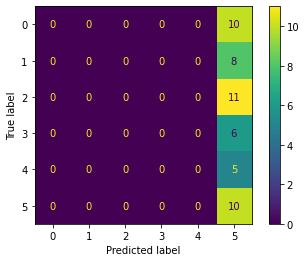

In [93]:
# Precision = TP / (TP + FP) is concerned with the proportion of predicted positives is truly positive (row)
# Recall  = TP / (TP + FN) is concerned with the proportion of actual positives are correctly classified (column)
# F1 score = 2 x (precision x recall) / (precision + recall). F1 scores need to be used with care because they give equal weigh to precision and recall!

# Predict on training data
y_pred = myLSTM.predict(yTrain)

# Preproces back to class labels
yPredRounded =np.argmax(y_pred, axis=1) # Convert from OHE back to single column of integers
yTestRounded = np.argmax(yTest, axis=1) # Convert from OHE back to single column of  integers
yPredString = [labelMapIntAsKey[integerLabel] for integerLabel in yPredRounded] # Convert labels from intergers to strings
yTestString = [labelMapIntAsKey[integerLabel] for integerLabel in yTestRounded] # Convert labels from intergers to strings

# Evaluate Confusion Matrix
cm = metrics.confusion_matrix(yTestString, yPredString)
cmDisp = metrics.ConfusionMatrixDisplay(cm, display_labels=[values for key, values in labelMap.items()])
cmDisp.plot()

# Evaluate Precision, Recall, F1-Score
print(metrics.classification_report(yTestString, yPredString))

# 6.2 ROC AUC Macro and Weighted For Multi-Class

In [76]:
# ROC is for binary classification. So we need to use One vs. One and One vs. Rest for multiclass classification.
# Note: ROC for multi-class can be macro or weighted since we need to effectively collapse the ROCs for each label into one metric.
# Good 0.8-0.9. Acceptable 0.7-0.8. Bad < 0.5.

macroAUC_OVO = metrics.roc_auc_score(yTest, y_pred, multi_class="ovo", average="macro")
weightedAUC_OVO = metrics.roc_auc_score( yTest, y_pred, multi_class="ovo", average="weighted")
print(f'Macro AUC OVO : {macroAUC_OVO:.3f}, Weighted AUC OVO: {weightedAUC_OVO:.3f}')

macroAUC_OVR = metrics.roc_auc_score(yTest, y_pred, multi_class="ovr", average="macro")
weightedAUC_OVR = metrics.roc_auc_score(yTest, y_pred, multi_class="ovr", average="weighted")
print(f'Macro AUC OVR : {macroAUC_OVR:.3f}, Weighted AUC OVR: {weightedAUC_OVR:.3f}')

Macro AUC OVO : 0.456, Weighted AUC OVO: 0.447
Macro AUC OVR : 0.456, Weighted AUC OVR: 0.447


# 7 Conclusion